In [1]:
import pandas as pd
import os
from pathlib import Path

# Tutorial for handling Modelica models 
The aim of this tutorial is to show how to generate boundary files (.txt) for Modelica models, to load Modelica models on python, set up and launch simulations using **Modelitool**.

# 1. Proposed model 

In this tutorial, we create of model of following wall, tested a "real scale" bench. The Nobatek BEF (Banc d'Essais Façade) provides experimental cells to test building façade solutions. The heat exchanges in a cell are limited on 5 of its faces. The 6th face is dedicated to the tested solution. Internal temperature and hydrometry conditions can be controlled or monitored. External conditions are measured (temperatures and solar radiation).  we propose a resistance/capacity approach.


| Figure : Pictures and model of the bench tested wall |
| :---: |
| <img src="images/etics_pict.png" style="height:200px;">  <img src="images/etics_sch.png"  style="height:200px;"> |

Based on electrical circuit analogy, each layer of the wall is modeled by two resistance and a capacity.
The model was built using openModelica : 

<img src="images/OM_eticsmodel.png"  height="200">

The following is a brief description of the thermal model, as it is not the scope of this document. See the <code>*mo</code> for full informations.

- Each wall layer is modeled by 2 thermal resistances and a capacity.
    - Resistances : $ R_1 = R_2 = \frac{ep_{layer}}{lambda_{layer} \times 2} $
    - Capacity : $ C = ep_{layer} \times rho_{layer} \times cap_{layer} $

    
- Inside and outside convection/conduction transfers are model as a constant value thermal resistance.


- Infrared transfers are considered :
    - With the sky, with $ T_{sky} = 0.0552T_{ext}^{1.5} $
    - With the surrounding considered to be at $ T_{ext} $


- Short wave solar radiation heat flux is computed $Sw_{gain} = Pyr \times \alpha_{coat} $ with $Pyr$ the measured solar radiation onthe wall (W/m²) and  $\alpha_{coat}$ the coating solar absorbtion coefficient.


- Temperatures $ T_{ext}$ and $T_{int} $ are boundary conditions


Initial conditions for the layers temperatures are taken from the measured data.

# 2. Set boundary file
## Option A: load csv file
Let's load measurement data on python. We can use this dataframe to define boundary conditions of our model.

In [2]:
TUTORIAL_DIR = Path(os.getcwd()).as_posix()

In [3]:
reference_df = pd.read_csv(
    Path(TUTORIAL_DIR) / "resources/study_df.csv",
    index_col=0,
    parse_dates=True
)    

## Option B: Create boundary file for Modelica model
Or, before loading the Modelica model (*.mo), one might want to generate boundary files with the right format (.txt) to use it their model. For this, you can use combitabconvert from modelitool.

Make sure beforehand your data is clean: no NAs, non monotonically increasing index, abberant values, etc.

**_Note : Note that you have to manually configure the file path in
the <code>combiTimetable</code> of your modelica model_**

In [4]:
from modelitool.combitabconvert import df_to_combitimetable

In [5]:
df_to_combitimetable(
    df=reference_df.loc["2018-03-22":"2018-03-23"],
    filename="resources/boundary_temp.txt"
)

# 3. Load model from Modelica

To avoid loading all ouptut from modelica model, let's first define a list of output that will be included in the dataframe output for any simulation.

In [6]:
output_list  = [
    "T_coat_ins.T",
     "T_ins_ins.T",
     "Tw_out.T"
]

Now, we can load the *om file.

The `OMModel` class is used to load and simulate Modelica models. It requires the following parameters:

- `model_path`: Path to the Modelica model file (*.mo) or model name if already loaded in OpenModelica
- `package_path` (optional): Path to additional Modelica packages required by the model
- `boundary_table` (optional): Name of the boundary condition table in the Modelica model
- `simulation_options` (optional): Dictionary containing simulation settings like:
  - `startTime`: Start time in seconds
  - `stopTime`: Stop time in seconds
  - `stepSize`: Time step for the simulation
  - `tolerance`: Numerical tolerance for the solver
  - `solver`: Solver to use (e.g. "dassl")
  - `outputFormat`: "mat" or "csv" for results format
  - `boundary`: Boundary conditions as a DataFrame
- `output_list` (optional): List of variables to include in simulation results
- `lmodel` (optional): List of required Modelica libraries (e.g. ["Modelica"])

In [7]:
from modelitool.simulate import OMModel

In [9]:
simu_OM = OMModel(
    model_path=Path(TUTORIAL_DIR) / "resources/etics_v0.mo",
    boundary_table="Boundaries",
    output_list=output_list,
    lmodel=["Modelica"],
)



         C_c.T:VARIABLE(min = max(0.0, max(0.0, max(0.0, 0.0))) start = Tcoat_init unit = "K" fixed = true nominal = 300.0 )  "Temperature of element" type: Real
         C_ins2.T:VARIABLE(min = max(0.0, max(0.0, max(0.0, 0.0))) start = Tins2_init unit = "K" fixed = true nominal = 300.0 )  "Temperature of element" type: Real
         C_ins1.T:VARIABLE(min = max(0.0, max(0.0, max(0.0, 0.0))) start = Tins1_init unit = "K" fixed = true nominal = 300.0 )  "Temperature of element" type: Real
         C_w.T:VARIABLE(min = max(0.0, max(0.0, max(0.0, 0.0))) start = Twall_init unit = "K" fixed = true nominal = 300.0 )  "Temperature of element" type: Real



#### Set up simulation options 

As they were not specified when instantiating OMModel, simulation running options (if different from the one provided by the modelica model) should be defined.

In Modelica, <code>startTime</code> and <code>stopTime</code> correspond to the number
of seconds since the beginning of the year. 

The values can be found in the file created earlier using <code>df_to_combitimetable</code> . Another way is to use the index of the <code>DataFrame</code> we just created.
The modelitool function <code>modelitool.combitabconvert.datetime_to_seconds</code>
helps you convert datetime index in seconds.


In [10]:
from modelitool.combitabconvert import datetime_to_seconds

In [11]:
simulation_df = reference_df.loc["2018-03-22":"2018-03-23"]
second_index = datetime_to_seconds(simulation_df.index)

- <code>stepSize</code> is the simulation timestep size. In this case it's 5 min or
300 sec.
- <code>tolerance</code> and <code>solver</code> are related to solver configuration
do not change if you don't need to.
- <code>outputFormat</code> can be either csv or mat. csv will enable faster data handling during sensitivity analyses and optimizations.
- <code>boundary</code>: as the boundary conditions.
-

In [12]:
simulation_opt = {
        "startTime": second_index[0],
        "stopTime": second_index[-1],
        "stepSize": 300,
        "tolerance": 1e-06,
        "solver": "dassl",
        "outputFormat": "csv",
        "boundary": reference_df
}

# 4.  Running a simulation

To run a simulation, use the `simulate()` method.

- `property_dict` (optionnal) : dictionary of model parameters to override before the run.
- `simulation_options` (optionnal if they were not specified when the model was instantiated): standard OpenModelica options such as  `"startTime"`, `"stopTime"`, `"stepSize"`, `"tolerance"`, `"solver"`, `"outputFormat"`.
- `simflags` *(str)*: additional OpenModelica simulation flags (⚠️ except `override`)
-  **`year`** *(int)*: if `boundary` uses integer seconds as index, the reference year to build a datetime index
-  **`verbose`** *(bool)*: whether to print simulation progress (default: `True`)

The output is a `pandas.DataFrame` with the simulation results.

In [13]:
simu_OM.simulate()

,T_coat_ins.T,T_ins_ins.T,Tw_out.T
time,,,
6912000,292.150000,292.150000,292.150000
6912300,279.219127,292.076800,292.197141
6912600,278.064419,291.977758,292.243893
6912900,277.510083,291.873904,292.290237
6913200,277.359645,291.769535,292.336176
...,...,...,...
7083300,280.606951,290.948899,298.087394
7083600,280.784373,290.925609,298.087642
7083900,281.067211,290.904458,298.087928


The initial values and parameter values can either be set before simulation (with the `set_param_dict()` method), or when using `simulate()`. Each change of parameter value overwrite the previous one.

In [14]:
parameter_dict_OM = {
    "Twall_init": 24.81 + 273.15,
    "Tins1_init": 19.70 + 273.15,
    "Tins2_init": 10.56 + 273.15,
    "Tcoat_init": 6.4 + 273.15,
    'Lambda_ins.k': 0.454,
}

simu_OM.set_param_dict(parameter_dict_OM)

The new set values of parameters in the model can be checked using `get_property_values()`:

In [15]:
simu_OM.get_property_values(parameter_dict_OM)

[['297.96'],
 ['292.84999999999997'],
 ['283.71'],
 ['279.54999999999995'],
 ['0.454']]

Additional options can be specified in the `simulate()` method. The output  is a Pandas DataFrame containing the results.
If an `output_list` was provided when creating the model, only those variables are included.

In [21]:
init_res_OM = simu_OM.simulate(
    simulation_options=simulation_opt,
    property_dict=parameter_dict_OM,
    simflags="-initialStepSize=60 -maxStepSize=3600 -w -lv=LOG_STATS",
)
init_res_OM.head()

,T_coat_ins.T,T_ins_ins.T,Tw_out.T
time,,,
2018-03-22 00:00:00,279.642336,288.280000,296.364443
2018-03-22 00:05:00,279.566014,288.235204,296.299314
2018-03-22 00:10:00,278.771034,288.156841,296.243018
2018-03-22 00:15:00,278.304966,288.031247,296.191068
2018-03-22 00:20:00,278.164364,287.899711,296.141231


Plotted results

<Axes: xlabel='time'>

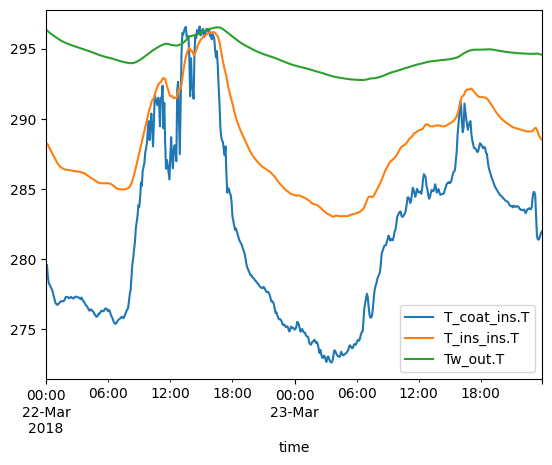

In [17]:
init_res_OM.plot()